In [1]:
import numpy as np
import pickle
import os
import cv2
import math
import face_alignment
import matplotlib.pyplot as plt
import scipy.linalg as linalg

In [2]:
def vis_landmark_on_img(img, shape, linewidth=2):
    '''
    Visualize landmark on images.
    '''
    def draw_curve(idx_list, color=(0, 255, 0), loop=False, lineWidth=linewidth):
        for i in idx_list:
            cv2.line(img, (shape[i, 0], shape[i, 1]), (shape[i + 1, 0], shape[i + 1, 1]), color, lineWidth)
        if (loop):
            cv2.line(img, (shape[idx_list[0], 0], shape[idx_list[0], 1]),
                     (shape[idx_list[-1] + 1, 0], shape[idx_list[-1] + 1, 1]), color, lineWidth)

    draw_curve(list(range(0, 16)), color=(255, 144, 25))  # jaw
    draw_curve(list(range(17, 21)), color=(50, 205, 50))  # eye brow
    draw_curve(list(range(22, 26)), color=(50, 205, 50))
    draw_curve(list(range(27, 35)), color=(208, 224, 63))  # nose
    draw_curve(list(range(36, 41)), loop=True, color=(71, 99, 255))  # eyes
    draw_curve(list(range(42, 47)), loop=True, color=(71, 99, 255))
    draw_curve(list(range(48, 59)), loop=True, color=(238, 130, 238))  # mouth
    draw_curve(list(range(60, 67)), loop=True, color=(238, 130, 238))

In [115]:
def norm_input_face(shape_3d):
    scale = np.linalg.norm(shape_3d[16] - shape_3d[0]) 
    shift = - 0.5 * (shape_3d[0] + shape_3d[16])
    shape_3d = (shape_3d + shift) / scale
    return shape_3d, scale, shift
def norm_mouth(shape_3d):
    scale = np.linalg.norm(shape_3d[54] - shape_3d[48]) 
    shift = - 0.5 * (shape_3d[48] + shape_3d[54])
    shape_3d = (shape_3d + shift) / scale
    return shape_3d, scale, shift

In [116]:
def rotationMatrixToEulerAngles(R) :
    sy = math.sqrt(R[0,0] * R[0,0] + R[1,0] * R[1,0])
    singular = sy < 1e-6
    if not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z])

def get_EulerAugles(centered):
    rotationMatrix = np.empty((3,3))
    rotationMatrix[0,:] = (centered[16] - centered[0])/np.linalg.norm(centered[16] - centered[0]) 
    rotationMatrix[1,:] = (centered[8] - centered[27])/np.linalg.norm(centered[8] - centered[27]) 
    rotationMatrix[2,:] = np.cross(rotationMatrix[0, :], rotationMatrix[1, :]) 
    eulerAngles = rotationMatrixToEulerAngles(rotationMatrix) 
    pitch, yaw, roll = eulerAngles
    return pitch, yaw, roll

In [117]:
predictor = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cpu', flip_input=True)

In [119]:
image_path = r'F:\code\avatar\tools\image\75660750-09419780-5c64-11ea-9d2f-97666e6ec82a.jpg'
img = cv2.imread(image_path)
shapes = predictor.get_landmarks(img) 
shapes = shapes[0]
shapes_n, scale, shift = norm_input_face(shapes.copy())
pitch, yaw, roll = get_EulerAugles(shapes_n)

In [99]:
get_EulerAugles(shapes)

(0.16020904834189786, -0.2082242546208394, -0.4493021967164994)

In [100]:
get_EulerAugles(shapes_n)

(0.16020905589903311, -0.20822427563954451, -0.44930228054256477)

In [102]:
pitch, yaw, roll

(0.16020905589903311, -0.20822427563954451, -0.44930228054256477)

In [103]:
def rotate_mat(axis, radian):
    rot_matrix = linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * radian))
    return rot_matrix

## 原始landmarks

In [69]:
def vis_landmark(shape, linewidth=2):
    '''
    Visualize landmark on images.
    '''
    def draw_curve(idx,color,loop=False):
        plt.plot(shape[idx, 0], shape[idx, 1],color=color) # 
#         plt.plot(shape[idx[-1]+1, 0], shape[idx[-1], 1])
        if (loop):
            plt.plot([shape[idx[0], 0],shape[idx[-1], 0]],[shape[idx[0], 1], shape[idx[-1], 1]],color=color)

    draw_curve(list(range(0, 17)),'b')  # jaw
    draw_curve(list(range(17, 22)),'lime')  # eye brow
    draw_curve(list(range(22, 27)),'lime')
    draw_curve(list(range(27, 36)),'c')  # nose
    draw_curve(list(range(36, 42)),'tomato',loop=True)  # eyes
    draw_curve(list(range(42, 48)),'tomato',loop=True)
    draw_curve(list(range(48, 60)),'m',loop=True)  # mouth
    draw_curve(list(range(60, 67)),'m',loop=True)

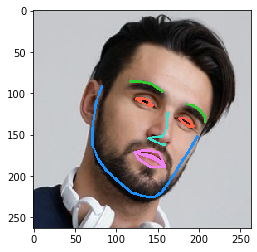

In [120]:
vis_landmark_on_img(img,shapes)
plt.imshow(img[:,:,::-1])
plt.show()

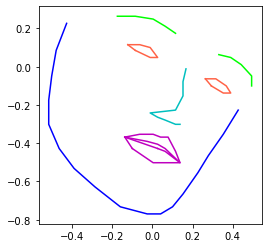

In [124]:
rot_shapes = shapes_n.copy()
rot_shapes[:,1] = -rot_shapes[:,1]
plt.figure(figsize=(4,4))
vis_landmark(rot_shapes)
plt.show()

## 计算旋转信息

In [125]:
pitch, yaw, roll = get_EulerAugles(rot_shapes)

In [126]:
pitch, yaw, roll

(2.9813836672449416, 0.2082242982776135, -0.44930225327186235)

## 沿y,z旋转

No handles with labels found to put in legend.


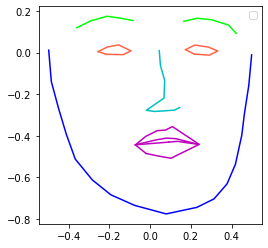

In [130]:
axis_x, axis_y, axis_z = [1,0,0], [0,1,0], [0, 0, 1]
rot_matrix_y = rotate_mat(axis_y, yaw)
rot_matrix_z = rotate_mat(axis_z, roll)
rot_shapes = shapes_n.copy()
rot_shapes[:,1] = -rot_shapes[:,1]
roted_shapes = np.dot(rot_shapes,rot_matrix_y)
roted_shapes = np.dot(roted_shapes,rot_matrix_z)
plt.figure(figsize=(4,4))
vis_landmark(roted_shapes)
plt.legend()
plt.show()

In [131]:
roted_shapes[0]

array([-0.4986812 ,  0.01131361,  0.03448334])

In [132]:
roted_shapes[16]

array([ 0.4986812 , -0.01131361, -0.03448334])